In [249]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import griddata
from scipy.optimize import curve_fit

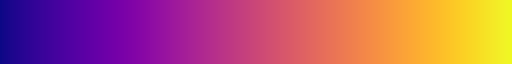

In [250]:
cm.plasma

In [322]:
def plot_pressure(file, probe_time, title,fontsize,skip_factor=1):
    data            = pd.read_table(file,sep="\s+",header=None)
    data            = np.array(data)
    
    # skip every skip_factor timestep; (I used way too many outputs along the calculation)
    radius          =   data[::skip_factor,0] * 1e4
    time            =   data[::skip_factor,1]
    
    # convert data to GPa
    press           =   data[::skip_factor,2]/1e3 
    # remove negative pressures
    press[press < 0.]   = 0.
    print(press.shape)
    
    # define the limits
    r_min           =   0.
    r_max           =   radius.max()
    t_min           =   0.
    t_max           =   time.max()
    
    # do the interpolation
    xi = np.linspace(r_min,r_max,800) 
    yi = np.arange(t_min,t_max,0.1)
    print(f'shape of xi is: {xi.shape}')
    print(f'shape of yi is: {yi.shape}')
    xi,yi = np.meshgrid(xi,yi)
    zi = griddata((radius,time),press,(xi,yi),method='linear',fill_value=0.)
    print(f'shape of xi is: {xi.shape}')
    print(f'shape of yi is: {yi.shape}')
    print(f'shape of zi is: {zi.shape}')
    
    
    # Do the actual plot
    #%matplotlib notebook
    fig = plt.figure(figsize=(13,14))  #viridis,plasma,magma
    grid = plt.GridSpec(4, 4, hspace=0.3, wspace=0.3)

    main_ax = fig.add_subplot(grid[:-1, :])
    pc = main_ax.pcolormesh(xi,yi,zi,cmap=cm.jet,shading='auto')
    cbar = fig.colorbar(pc)
    cbar.set_label('Pressure (GPa)',fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize) 
    
    x_hist = fig.add_subplot(grid[-1, :],sharex=main_ax)

    def format_coord(x, yS):
        xarr = xi[0,:]
        yarr = yi[:,0]
        if ((x > xarr.min()) & (x <= xarr.max()) & 
            (y > yarr.min()) & (y <= yarr.max())):
            col = np.searchsorted(xarr, x)-1
            row = np.searchsorted(yarr, y)-1
            z = zi[row, col]
            return f'x={x:1.4f}, y={y:1.4f}, z={z:1.4f}   [{row},{col}]'
        else:
            return f'x={x:1.4f}, y={y:1.4f}'
    
    main_ax.format_coord = format_coord
    
    main_ax.set_xlabel('Position',fontsize=fontsize)
    main_ax.set_ylabel('Time',fontsize=fontsize)
    main_ax.tick_params(axis='x', labelsize=fontsize)
    main_ax.tick_params(axis='y', labelsize=fontsize)
    #plt.savefig(title,dpi=100)
    return fig, xi, yi, zi, grid, main_ax, x_hist

In [323]:
def add_profile(probe_time, xi, yi, zi, x_hist, main_ax, color, fontsize):

    ### pressure linout at the breakout time
    t0 = probe_time
    main_ax.axhline(y=t0,linewidth=5,ls=":",c=color)
    #x_hist = fig.add_subplot(grid[-1, :],sharex=main_ax)
    #index of time values closest to t0
    id_t0 = np.abs(yi[:,0] - t0).argmin()
    #pressure values at that time
    z_t0 = zi[id_t0,:]
    x_hist.plot(xi[0],z_t0,linewidth=2,c=color,label=f'{probe_time}ns')
    x_hist.set_xlabel(r'Position ($\mu$m)',fontsize=fontsize)    
    x_hist.set_ylabel(r'$P$ (GPa)',fontsize=fontsize)

In [324]:
def add_boundary(file, main_ax):
    f               = open(file)
    txt             = f.read()
    f.close()
    pattern          = 'Dataset:\s+'
    regions          = []
    boundary         = []
    linestyles       = [
     ('loosely dashed',        (0, (5, 10))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

    for region in re.split(pattern,txt)[1:]:
        regions.append(re.split('\n', region)[0])
        tmp         = re.split('#\s+X\s+Y\s*\n', region)[1]
        tmp         = re.split('#',tmp)[0]
        data        = np.array(tmp.split(),dtype=float).reshape(-1,2)
        print(data.shape)
        boundary.append(data)

    regions         = regions[2:]
    boundary         = boundary[2:]

    for bound_id in range(len(boundary)):
        print(boundary[bound_id].shape)
        main_ax.plot(boundary[bound_id][:,1],boundary[bound_id][:,0],c='w',linestyle=linestyles[bound_id][1],linewidth=3,label=regions[bound_id])
        #main_ax.scatter(boundary[bound_id][1] * 1e-4,boundary[bound_id][0],c='w',s=100.)

    return regions, boundary


In [325]:
def add_PET_boarders(boundary, times, colors, x_hist):
        for bound_id, probe_time in enumerate(times):
                interp_a          = np.interp(probe_time, boundary[0][:,0], boundary[0][:,1])
                interp_b          = np.interp(probe_time, boundary[1][:,0], boundary[1][:,1]) 
                print(f'PET at time {probe_time} goes from {interp_a} to {interp_b}')

                x_hist.axvline(x=interp_a,c=colors[bound_id],linestyle=(0, (5, 10)),linewidth=3)
                x_hist.axvline(x=interp_b,c=colors[bound_id],linestyle=(0, (3, 1, 1, 1)),linewidth=3)

(618762,)
shape of xi is: (800,)
shape of yi is: (140,)
shape of xi is: (140, 800)
shape of yi is: (140, 800)
shape of zi is: (140, 800)
(281, 2)
(281, 2)
(281, 2)
(281, 2)
(281, 2)
(281, 2)
PET at time 9.0 goes from 62.845192750670456 to 110.0
PET at time 10.0 goes from 67.53675632168728 to 116.50527102893506
PET at time 11.0 goes from 70.82154873625275 to 133.17282949410117


/tmp/ipykernel_11765/2465759667.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


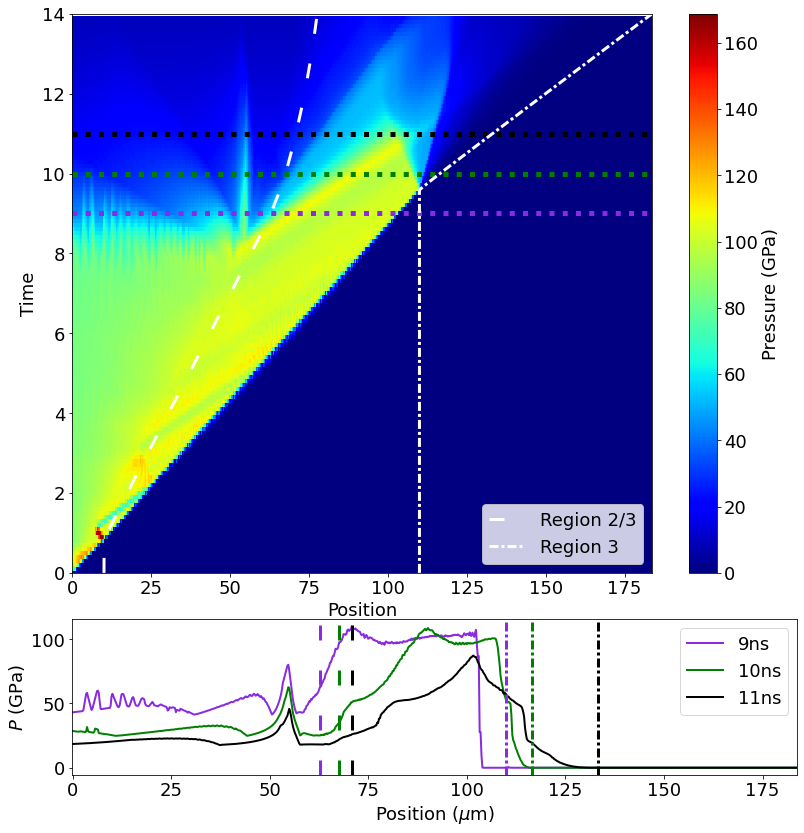

In [327]:
fontsize        = 18
fig, xi, yi, zi, grid, main_ax, x_hist = plot_pressure('../../.data_LW03/HELIOS/r190/P_t_vs_r_r192.dat',10.0,'../Figures/Pressure_HELIOS_r190.png', fontsize)
add_profile(9, xi, yi, zi, x_hist, main_ax, 'blueviolet',fontsize)
add_profile(10, xi, yi, zi, x_hist, main_ax, 'green',fontsize)
add_profile(11, xi, yi, zi, x_hist, main_ax, 'k',fontsize)
regions, boundary = add_boundary('../../.data_LW03/HELIOS/r190/region_boundary_r192.ppd',main_ax)
add_PET_boarders(boundary,[9.,10.,11.],['blueviolet','green','k'], x_hist)
main_ax.set_ylim(0.,14)
main_ax.legend(loc='lower right',fontsize=fontsize)
x_hist.tick_params('x',labelsize=fontsize)
x_hist.tick_params('y',labelsize=fontsize)
x_hist.legend(fontsize=fontsize)
fig.tight_layout()
fig.savefig('/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Presentations/Progress_presentation/figures/HELIOS_LW03_36J.pdf')

In [310]:
100 *1e-4

0.01

[[-5.19705e-09  1.00000e-06  8.34848e+02]
 [ 2.25002e-04  1.00000e-06  8.32542e+02]
 [ 4.63200e-04  1.00000e-06  8.30236e+02]
 ...
 [ 1.64053e+02  1.00001e+01  2.91845e-02]
 [ 1.65160e+02  1.00001e+01 -5.27115e-03]
 [ 1.65204e+02  1.00001e+01 -5.28551e-03]]
(442602,)
shape of xi is: (1000,)
shape of yi is: (101,)
shape of xi is: (101, 1000)
shape of yi is: (101, 1000)
shape of zi is: (101, 1000)


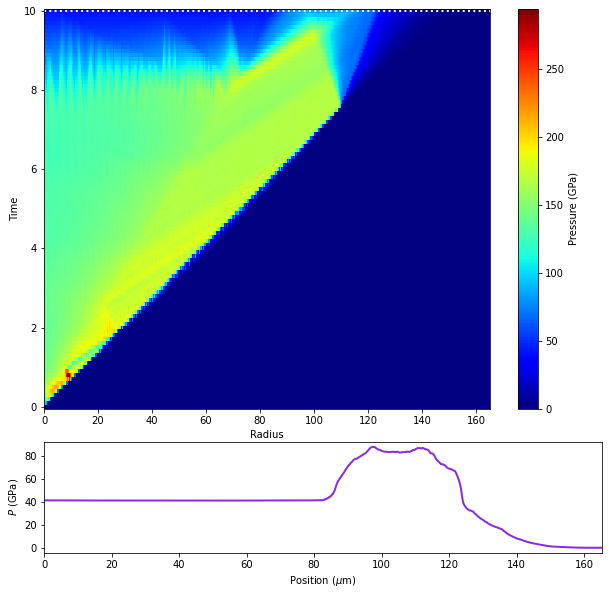

In [44]:
plot_pressure('../../.data_LW03/HELIOS/r282/r282_SESAME_real_pulse/r282_SESAME_real_pulse_plot_data.dat',10.0,'../Figures/Pressure_HELIOS_r190.png')

In [ ]:
def plot_temp(file, probe_time, title,skip_factor=1,cutoff=10000):
    data = pd.read_table(file,sep="\s+",header=None)
    data = np.array(data)
    
    # skip every skip_factor timestep; (I used way too many outputs along the calculation)
    radius=data[::skip_factor,0]
    time=data[::skip_factor,1]
    
    
    # convert temp to K
    temp=data[::skip_factor,2] * 11604.525
    
    # define the limits
    r_min =0.
    r_max =radius.max()
    t_min = 0.
    t_max = time.max()
    
    # do the interpolation
    xi = np.arange(r_min,r_max,0.1) 
    yi = np.arange(t_min,t_max,0.1)
    xi,yi = np.meshgrid(xi,yi)
    zi = griddata((radius,time),temp,(xi,yi),method='linear',fill_value=0.)
    
    # Remove all data above the cutoff value by setting them to zero
    #zi[np.where(zi > cutoff)] = 0.
    
    # Do the actual plot
    #%matplotlib notebook
    fig = plt.figure(figsize=(9,9))  #viridis,plasma,magma
    grid = plt.GridSpec(4, 4, hspace=0.3, wspace=0.3)

    main_ax = fig.add_subplot(grid[:-1, :])
    pc = main_ax.pcolormesh(xi,yi,zi,cmap=cm.gist_rainbow,shading='auto')
    cbar = fig.colorbar(pc)
    cbar.set_label('T (K)')

    ### pressure linout at the breakout time
    t0 = probe_time
    plt.axhline(y=t0,linewidth=2,ls=":",c="blueviolet")
    x_hist = fig.add_subplot(grid[-1, :],sharex=main_ax)
    #index of time values closest to t0
    id_t0 = np.abs(yi[:,0] - t0).argmin()
    #pressure values at that time
    z_t0 = zi[id_t0,:]
    line, = x_hist.plot(xi[0],z_t0,linewidth=2,c="k")
    plt.xlabel(r'Position ($\mu$m)')    
    plt.ylabel(r'$T$ (K)')
    
    def format_coord(x, yS):
        xarr = xi[0,:]
        yarr = yi[:,0]
        if ((x > xarr.min()) & (x <= xarr.max()) & 
            (y > yarr.min()) & (y <= yarr.max())):
            col = np.searchsorted(xarr, x)-1
            row = np.searchsorted(yarr, y)-1
            z = zi[row, col]
            return f'x={x:1.4f}, y={y:1.4f}, z={z:1.4f}   [{row},{col}]'
        else:
            return f'x={x:1.4f}, y={y:1.4f}'
    
    main_ax.format_coord = format_coord

    main_ax.set_xlabel('Radius',fontsize=10)
    main_ax.set_ylabel('Time',fontsize=10)
    plt.savefig(title,dpi=100)

In [125]:
def plot_breakout(file, probe_time, title,t0_VISAR, t0_HELIOS ,skip_factor=1):
    data = pd.read_table(file,sep="\s+",header=None)
    data = np.array(data)
    
    # skip every skip_factor timestep; (I used way too many outputs along the calculation)
    radius=data[::skip_factor,0]
    time=data[::skip_factor,1]
    
    # convert data to GPa
    press=data[::skip_factor,2]/1e3
    
    # define the limits
    r_min =0.
    r_max =radius.max()
    t_min = 0.
    t_max = time.max()
    
    # do the interpolation
    xi = np.arange(r_min,r_max,0.1) 
    yi = np.arange(t_min,t_max,0.1)
    xi,yi = np.meshgrid(xi,yi)
    zi = griddata((radius,time),press,(xi,yi),method='linear',fill_value=0.)
    
    
    # Do the actual plot
    #%matplotlib notebook
    fig, main_ax = plt.subplots(figsize=(10,10))  #viridis,plasma,magma

    pc = main_ax.pcolormesh(xi,yi,zi,cmap=cm.jet,shading='auto')
    cbar = fig.colorbar(pc)
    cbar.set_label('Pressure (GPa)') 

    ### pressure linout at the breakout time
    plt.axhline(y=t0_HELIOS,linewidth=4,ls=":",c="k")
    plt.text(10,t0_HELIOS + 0.25,"Breakout HELIOS",fontsize=20)
    
    plt.axhline(y=t0_VISAR,linewidth=4,ls=":",c="white")
    plt.text(10.,t0_VISAR - 0.6,"Breakout  VISAR",fontsize=20,color="white")

    main_ax.set_xlabel('Radius',fontsize=10)
    main_ax.set_ylabel('Time',fontsize=10)
    plt.savefig(title,dpi=100)

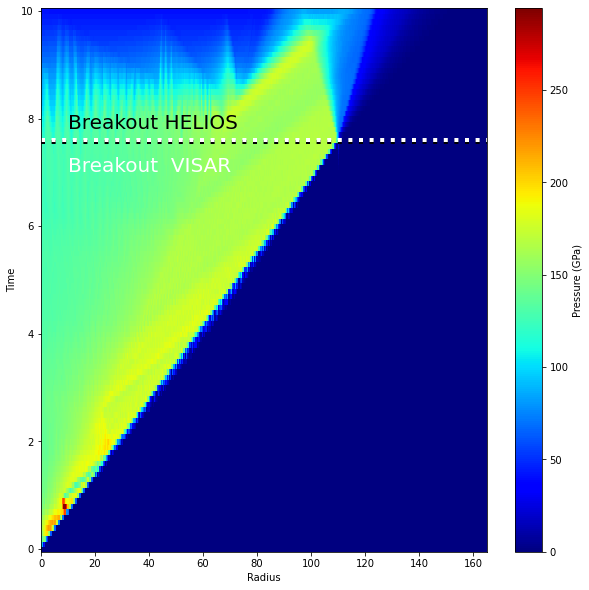

In [131]:
plot_breakout('../HELIOS/Al_PET_single_shocks/r282/r282_SESAME_real_pulse/r282_SESAME_real_pulse_plot_data.dat',7.,'../Figures/r282_breakout.png',t0_VISAR=7.61, t0_HELIOS=7.56)